# The IC notebook

## Manifesto

IC stands for Invisible Cities, the master piece of Italo Calvino. 

The project is a study on how to produce a truly python-like analysis "framework" (FMW). Actually, it is not even clear that the concept of "framework" needs to survive the experiment. One of IC goals is to understand to what extent the paradigma of a "loop + algorithms + services", which has reigned since decades in the World of particle physics (PP) remains valid. 

PP experiments tend to organize their data using an "event data model" or EDM, which describes the collection of objects which are manipulated by different algorithms, tipically harnessed by the FMW. A tipycal EDM will contain raw data, often organised a large multi-dimensional vectors, and then higher-level objects that are produced along the algorithm chain. In PP, the EDM are tipically expressed using object orientation, and persistency is handled by the ROOT library (which handles almost everything in PP software). 

Often, the data produced by PP experiments is reduced from pure "raw data" (e.g, ADC counts) to high level objects (e.g, "particles") which are then saved in a "Data Summary Tape" (some of us actually saw the tapes spinning) or DST. The collection of algorithms that carries out this taks are tipically part of the "Reconstruction suite" of the experiment, and almost excusively written in C++. Tipically, also, only a subset of experts write those algorithms, which deal with detector calibration, pedestal subtraction and various other low level chores.

The DST is, in practice, the starting point of most analysis. Analysis algorithms can be run with the same FMW used by reconstruction (thus C++) or with alternative "analysis frameworks". Some attempts of writting such analysis frameworks (AFMW) in python have been made, with mixed success. The reason is that the DST contains C++/ROOT objects, which need to be exposed to python. This is done using pyROOT, and in principle it provides a python version of the DST objects.

Alas, "in principle". The objects exposed by pyROOT to python are C++/ROOT objects. Most of the introspection and reflection capabilities of python are lost in translation, and the objects are only accesible trhough their interface. Then, one can find something like this:

std::vector<std::map<int,float> > gate::HitMap::GetTimeMap() const;

accessing the information of such an object from python is possible but certainly neither elegant, nor efficient.

The consequence is that python-pyROOT analysis code tends to be burdened by the restrictions imposed by the need to manipulate pyROOT objects. More in general, the ROOT library was developed for C++, and, as a matter of facts, its design and interfaces show its long story (which started as long ago as the HOBOOK library, possible even sooner). A python analysis based in ROOT can certainly used all the powerful tools that ROOT offers, but at a price, which goes beyond ROOT some-times difficult interfaces. The writer of code tends to do whaterver is allowed by ROOT, rather than whatever is more efficient, clear or elegant.

As an example, python offers the possibility to work with numpy arrays, which have become, de facto, the numerical power horse of the language. Numpy arrays are very fast and allow array-wise computations. For example


In [1]:
import numpy as np

In [6]:
t = np.array(range(10))

In [7]:
t2 = np.array(range(10))

In [8]:
a = 5*t + 10*t2

In [9]:
t

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
t2

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
a

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135])

Of course, nothing prevents us for combining numpy arrays and pyroot objects. But it is not trivial. For example, I could be retrieving this object from the DST


const gate::Vector4D& MCParticle::GetInitialMom() const ; 

which will store (px,py,pz,E) in an object of type vector4D. The object iteself can have an interface that allow us to manipulate 4-vectors, and thus one can do thins such as adding the momentum of two particles or computing the mass of the particle. The problem is that another object may come with a different interface:

gate::Point3D MCParticle::GetInitialVtx() const 

Which implies that one may end up spending a lot of human and CPU cycles copying and transforming objects (which are, not to forget opaque). 

An alternative is to handle numpy objects as the backbone of all the data storage and then write functions that manipulate them. Using numpy is very efficient in python, and the python eco-system has produced a number of high level tools to handle and store them (eg PANDAS, PYTABLES). A nice solution to store the data in the python eco-system is HDF5. This provides a very convenient standard, and furthermore, there are high level tools (pytables, h5py, pandas) that interface to it.

Handling the data is but a part of the problem. One also needs to perform mathematical operations (fitting functions, interpolating, numerical derivates and integration, etch). In the PP paradigm, ROOT will also take care of that. In the python ecosystem, SciPy and other libraries provide fast and efficient way to perform equivalent chores manipulating numpy arrays. 

Data representation and plotting comes next. ROOT will do it for PP. A suite of libraries (notably matplotlib, but there are others) will cover the job in python ecosystem.

Thus, one could argue that the ROOT/pyROOT approach usually followed in PP is convenient, since ROOT allows you to do everything with a single library. This, as a matter of fact, can be more evil than good, since you end up doing what you are allowed to do, rather than what you could possibly do.

IC is an attempt to experiment is there alternative ways to the well trodden path.

## NEW data as a case example

In [12]:
from IPython.display import Image

In [15]:
%ls Images

next-cartoon.png


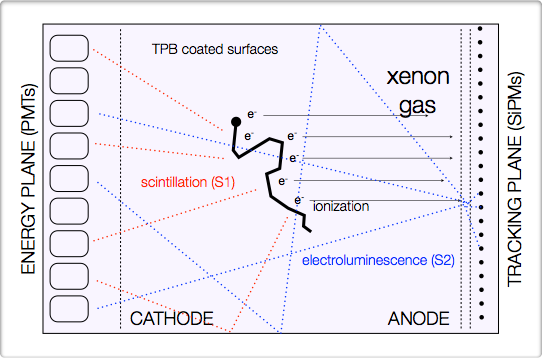

In [16]:
Image(filename='Images/next-cartoon.png')

The figure shows a cartoon of the NEW/NEXT detector(s). The important elements here:
1. An electron that propagates in the gas until it eventually stops. In the case of the Monte Carlo this electron is defined as a monte-carlo track (MCTrack) associated to a monte-carlo particle (MCParticle). The MCParticle would be an electron, created with some energy and initial momentum. The MCTrack represent the propagation of the electron through the physical medium (the xenon gas), from an initial vertex to a final vertex, leaving a number of "true-hits" along its paths (a convenient quantification of the electron trajectory). The EDM needs to capture the above concepts.
2. The primary electron produces primary scintillation and ionization electrons that drift under an intense electric field to the anode (keeping somewhere the information of the electric field is an example of the neef for metadata).
3. In the anode, the drift electrons are accelerated through the EL grid and produce light. Light going forward hits an array of silicon-photomultipliers (SiPMs). Light going backwards hits photomultiplers (PMTs). The SiPM plane is called the tracking plane, and the PMT plane is called the energy plane. The energy and tracking plane record the information of primary scintillation (S1) and amplified secondary EL scintillation (S2).
4. NEXT RAW data is given by the waveforms of the PMTs (12 for NEW) and the SiPMs (1792 for NEW)
5. Additional information such as the position, gains and calibration constants of the sensors is also needed

### Data structures

1. Geometry information (describes the detector, the level of detail depens on needs) -- run level 
2. Sensor information (positions, calibration constants, gains, masks for PMTs and SiPMs) -- run level
3. MC info (Monte Carlo track info: energy momentum, hits, etc.) ---event level, only applies to MC data
4. Raw data por PMTs and SiPMs (waveforms)

### Pytables implementation 

#### Geometry

class DetectorGeometry(tables.IsDescription):

    """
    Stores geometry information for the detector
    """
    
    x_det = tables.Float64Col(shape=2, pos=1) #xmin, xmax
    y_det = tables.Float64Col(shape=2, pos=2) #ymin, ymax
    z_det = tables.Float64Col(shape=2, pos=3) #zmin, zmax
    r_det = tables.Float64Col(pos=4) # radius


#### Sensors

class DataPMT(tables.IsDescription):

    """
    Stores metadata information for the PMTs
    (position, gain, calibration-constant, mask)
    """
    
    channel = tables.Int16Col(pos=1) #electronic channel
    active = tables.Int16Col(pos=2) # 1 if active. 0 if dead
    position = tables.Float64Col(shape=3, pos=3)
    gain =tables.Float64Col(pos=4)
    adc_to_pes =tables.Float64Col(pos=5)

class DataSiPM(tables.IsDescription):

    """
    Stores metadata information for the SiPMs
    (position, gain, calibration-constant, mask)
    """
    
    channel = tables.Int16Col(pos=1) #electronic channel
    active = tables.Int16Col(pos=2) # 1 if active. 0 if dead
    position = tables.Float64Col(shape=3, pos=3)
    gain =tables.Float64Col(pos=4)
    adc_to_pes =tables.Float64Col(pos=5)

#### Monte Carlo tracks

class MCTrack(tables.IsDescription):

    """
    Stores the parameters used by the simulation as metadata
    using Pytables
    """
    
    event_indx = tables.Int16Col(pos=1) 
    mctrk_indx = tables.Int16Col(pos=2) 
    particle_name = tables.StringCol(10,pos=3)  #displaces the baseline (e.g, 700)
    pdg_code = tables.Int16Col(pos=4)   # number of PMTs (12) 
    initial_vertex =tables.Float64Col(shape=3, pos=5)
    final_vertex =tables.Float64Col(shape=3, pos=6)
    momentum =tables.Float64Col(shape=3, pos=7)
    energy =tables.Float64Col(pos=8)
    nof_hits = tables.Int16Col(pos=9) 
    hit_indx = tables.Int16Col(pos=10)
    hit_position = tables.Float64Col(shape=3, pos=11)
    hit_time =tables.Float64Col(pos=12)
    hit_energy =tables.Float64Col(pos=13)

#### PMT and SiPM raw data (using pyTables EVectors)

self.pmtrd = self.h5f.create_earray(self.h5f.root, "pmtrd", atom=tables.IntAtom(), 
                                    shape=(0, self.NPMTS, self.LEN_PMT), 
                                    expectedrows=self.NEVENTS)
                                    

self.sipmrd = self.h5f.create_earray(self.h5f.root, "sipmrd", 
                                    atom=tables.IntAtom(), 
                                    shape=(0, self.NSIPM, self.LEN_SIPM), 
                                    expectedrows=self.NEVENTS)

PMT and SiPM vectors are stores in 3d earrays (NEVENTS, sensor_number, waveform)

## Simulating the response of the energy plane

The front-ed electronics of the NEW energy plane (FEE) decouples de DC from the signal through a decoupling capacitor, which in turns acts (together with the corresponding resistor) as a HPF filter

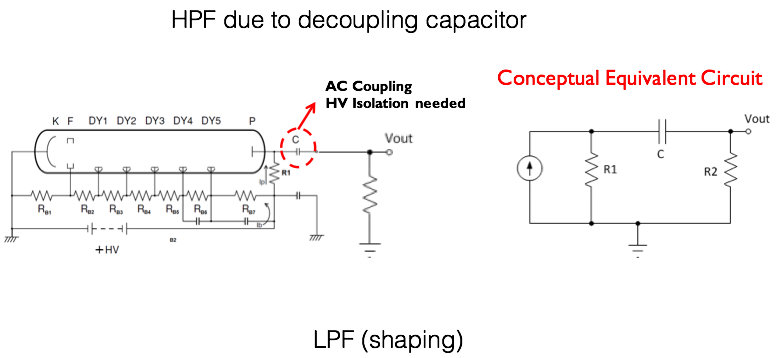

In [18]:
Image(filename='Images/FEE.png')

The filter introduces a negative swing in the signal, which can be corrected through digital baseline restorarion (DBLR). This is easy to see:

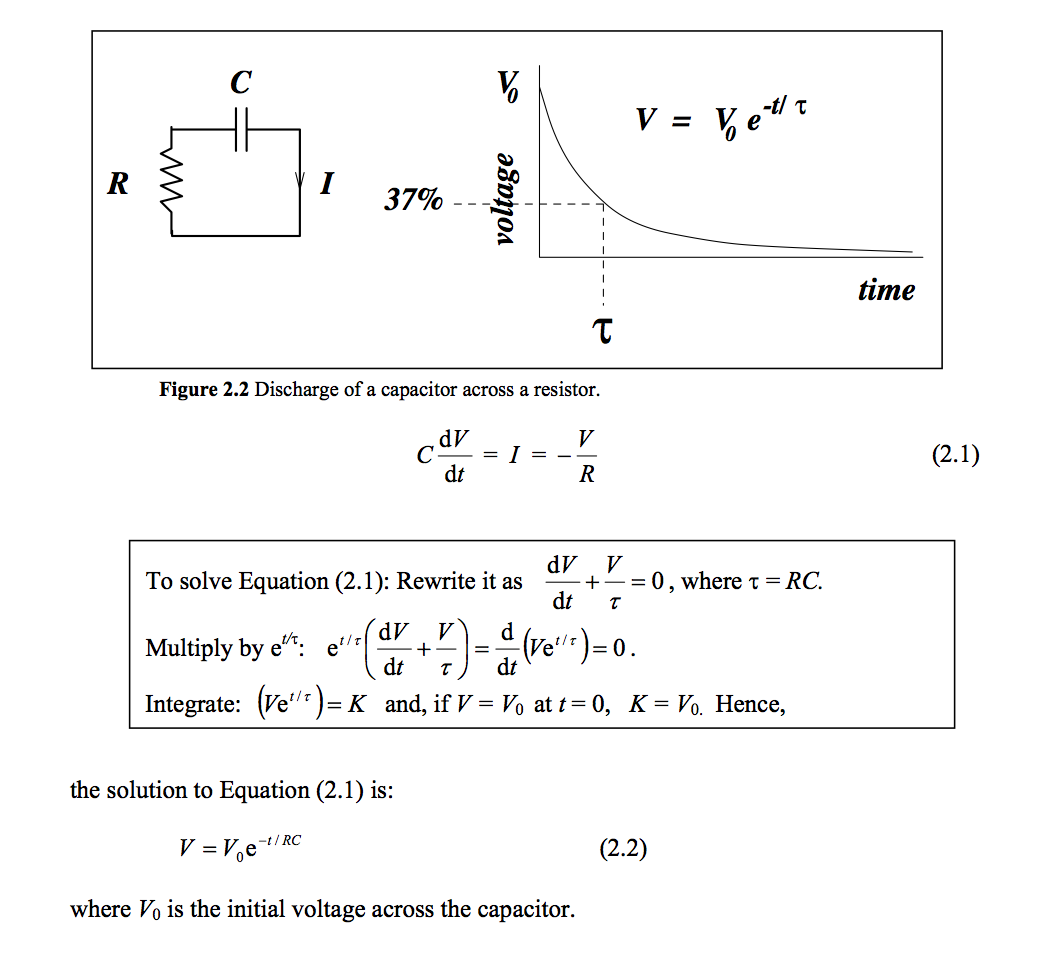

In [19]:
Image(filename='Images/RC-circuit.png') 

### CR diferentiator or High Pass Filter (HPF)

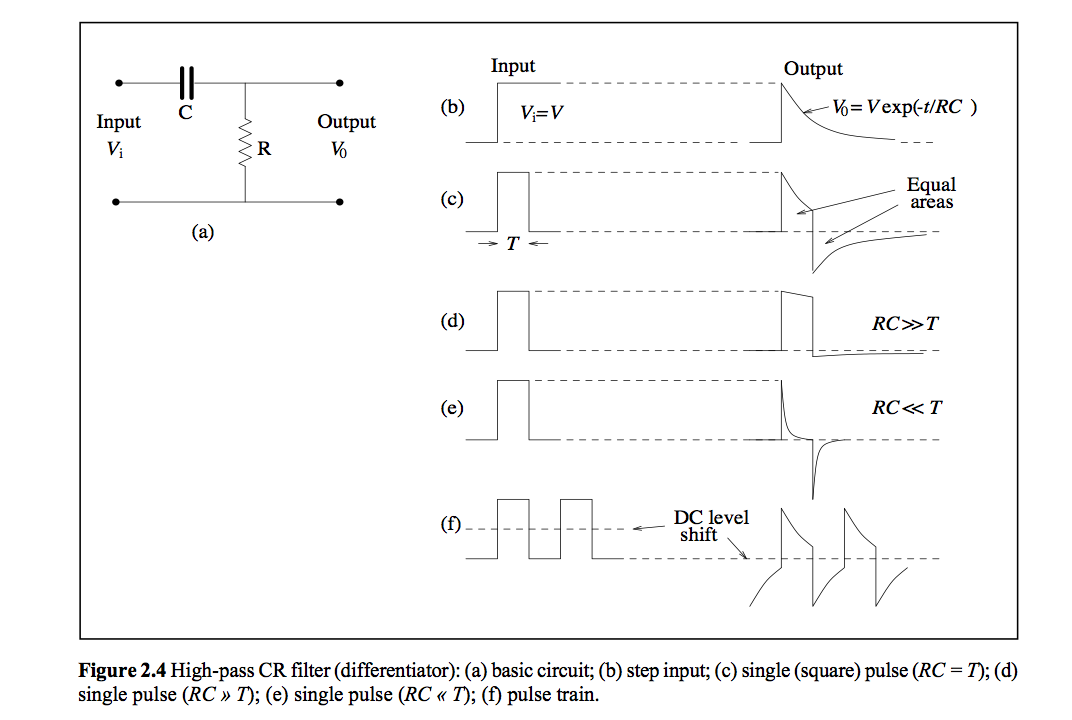

In [20]:
Image(filename='Images/CR-differentiator.png')  

The diferentiation implies that the positive and negative areas are the same. This needs to be handled since the area of the PMT pulse is proportional to the number of photoelectrons recorded (and thus to the energy of the particle). For short pulses (compared with RC) the effect is small, but it becomes large for long pulses compared with RC

### Simulation of the PMT signals

1. To simulate the signals of the PMTs, one needs to start with an input signal, which can be, for example a square pulse (used for calibration), or a simulation of the physical signal that the PMT receives. In any case the "waveform" describing the signal must be densely binned to simulate a continous signal. Given that the DAQ will sample each 25 ns, a reasonable bin for the input waveform is 1 ns. 

2. The input waveform is then described as a continous (1 ns) train of photoelectrons. The PMT response to each photoelectron is simulated following the experimental input as a trapezoidal pulse. An example is shown in the notebook "PMT simulation".

3. The output of the PMT is then passed by a HPF defined by the RC constant (plus an additional LPF filter used for shaping) and decimated by the DAQ. The resulting signal shows the diferentiation introduced by the filter.

4. Finally, the new waveforms (in bins of 25 ns and in adc counts) must be stored. 

5. It follows that for MC data, the initial waveforms of the PMTs (in photoelectrons per 1 ns bin) is transformed in a signal (adc counts per 25 ns bins) which reflects the effect of the PMT and electronics. This new waveform needs to be stored and eventually one can drop the very large initial waveform. It is important, however, to save the true information about the total number of photoelectrons in each PMT before the FEE, to be compared with the number of photoelectrons computed once the signal is deconvoluted. 